In [0]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import imgaug as ia
from tqdm import tqdm
from imgaug import augmenters as iaa
import numpy as np
import os, cv2
from PIL import Image
import json

**Converting the annotations.json file to the required dataframes**

In [0]:
dict1={}
x1_dict={}
x2_dict={}
y1_dict={}
y2_dict={}
e=[]
with open('/content/red/annotations.json') as json_data:
    d = json.load(json_data)
a=d['imgs'].keys()
k=list(a)
#print(k)
signs=["p1","p2","p3","p4","p5","p6","p7","p8","p9",
    "p10","p11","p12","p13","p14","p15","p16","p17","p18","p19","p20","p21",
    "p22","p23","p24","p25","p26","p27","p28","pn","pnl","pl*","pr*","ph*","pw*"
    ,"pb","pe","pne","pl40"]
for l in range(0,len(k)-15000):
  g=k.pop()
  if len(d["imgs"][g]["objects"])!=0:
    length=len(d["imgs"][g]["objects"])
    for u in range(0,length):
        if d["imgs"][g]["objects"][u]["category"] in signs:
          im2= g
          try:
            im = Image.open("/content/red/JPEGImages/"+ im2+'.jpg')
          except:
            continue
          width, height = im.size
          b=d['imgs'][g]['objects'][u]['category']
          c={g:b}
          dict1.update(c)
          x_min=d["imgs"][g]["objects"][u]["bbox"]["xmin"]/width
          xsmall={g:x_min}
          x1_dict.update(xsmall)
          x_max=d["imgs"][g]["objects"][u]["bbox"]["xmax"]/width
          xbig={g:x_max}
          x2_dict.update(xbig)
          y_min=d["imgs"][g]["objects"][u]["bbox"]["ymin"]/width
          ysmall={g:y_min}
          y1_dict.update(ysmall)
          y_max=d["imgs"][g]["objects"][u]["bbox"]["ymax"]/width
          ybig={g:y_max}
          y2_dict.update(ybig)
          e.append(g)
df1=pd.DataFrame(dict1.items(), columns=['ImageID', 'sign'])
df2 = pd.DataFrame(x1_dict.items(),columns=['ImageID', 'XMin'])
df_merge_difkey = pd.merge(df1, df2 , left_on='ImageID', right_on='ImageID')
df3=pd.DataFrame(x2_dict.items(),columns=['ImageID', 'XMax'])
df4=pd.DataFrame(y1_dict.items(),columns=['ImageID', 'YMin'])
df5=pd.DataFrame(y2_dict.items(),columns=['ImageID', 'YMax'])
df_merge_difkey1 = pd.merge(df_merge_difkey, df3 , left_on='ImageID', right_on='ImageID')
df_merge_difkey2 = pd.merge(df_merge_difkey1, df4 , left_on='ImageID', right_on='ImageID')
subset_data_merged = pd.merge(df_merge_difkey2, df5 , left_on='ImageID', right_on='ImageID')
df1.head()
subset_data_merged["class_name"]="Red_round_sign"
print(subset_data_merged )


**Extracting the images from the zip file**

In [0]:
!pip install patool
import patoolib
%cd /content/red
patoolib.extract_archive("JPEGImages.rar", outdir="/content/red")


In [0]:
import os
train_image_ids = os.listdir('/content/red/JPEGImages/')

In [0]:
subset_imageids = []
for image_id in train_image_ids:
    image_id = image_id.replace('.jpg','')
    subset_imageids.append(image_id)

In [0]:

# Checking if there are any missing values for Class labels
subset_data_merged['class_name'].isna().sum()

0

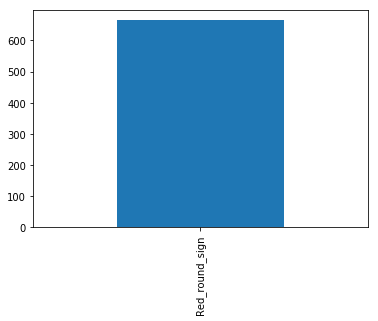

In [0]:
# Getting the top 20 objects in our data
subset_data_merged['class_name'].value_counts()[:20].plot(kind='bar')

In [0]:
# Exporting the subset data to csv
#subset_data_merged.to_csv('/content/Subset_images_data.csv')

In [0]:
subset_data_merged = pd.read_csv('/content/Subset_images_data.csv')

In [0]:
# Get the list of all the images which are present in the subset of train data (200K images)
import os
train_image_ids = os.listdir('/content/red/JPEGImages/')

In [0]:
new_dict = {}
new_dict1 = {}
%pylab inline
from PIL import Image
for i in train_image_ids:
    im = Image.open("/content/red/JPEGImages/"+ i)
    width, height = im.size
    image = i.replace('.jpg','')
    new_dict[image]= (width)
    new_dict1[image]= (height)
print(new_dict)

In [0]:
# Creating data frame from dictionary
new_df1=pd.DataFrame(new_dict.items(),columns=[ 'ImageID','height'])
new_df2=pd.DataFrame(new_dict.items(),columns=[ 'ImageID','width'])
new_df = pd.merge(new_df1,new_df2,left_on = 'ImageID',right_on = 'ImageID')


In [0]:
new_df

,ImageID,height,width
0,95482,2048,2048
1,62526,2048,2048
2,97536,2048,2048
3,31530,2048,2048
4,97074,2048,2048
5,83962,2048,2048
6,26789,2048,2048
7,30699,2048,2048
8,30949,2048,2048
9,96132,2048,2048


**Dataframe with all the required data to implement yolo**

In [0]:
merged_df = pd.merge(subset_data_merged,new_df,left_on = 'ImageID',right_on = 'ImageID')
merged_df

,ImageID,sign,XMin,XMax,YMin,YMax,class_name,height,width
0,32764,p26,0.350322,0.361948,0.459604,0.472393,Red_round_sign,2048,2048
1,65531,pl40,0.933105,0.981445,0.487793,0.547363,Red_round_sign,2048,2048
2,22913,pn,0.114746,0.129395,0.491699,0.509766,Red_round_sign,2048,2048
3,32751,p9,0.138672,0.174316,0.411133,0.454102,Red_round_sign,2048,2048
4,32719,pn,0.103972,0.120977,0.374349,0.401314,Red_round_sign,2048,2048
5,32706,p11,0.543252,0.550044,0.457885,0.467586,Red_round_sign,2048,2048
6,98237,p25,0.772788,0.803385,0.309896,0.341797,Red_round_sign,2048,2048
7,65456,pl40,0.651855,0.680176,0.291992,0.319336,Red_round_sign,2048,2048
8,65455,pne,0.641016,0.664453,0.373047,0.394531,Red_round_sign,2048,2048
9,65450,p10,0.862793,0.875977,0.515625,0.529297,Red_round_sign,2048,2048


In [0]:
# Exporting the merged data frame to csv
merged_df.to_csv('/content/subset_data_with_imagesize.csv',index = False)

In [0]:
open_image_data = pd.read_csv('/content/subset_data_with_imagesize.csv')

In [0]:
image_dir = '/content/red/JPEGImages/'

# Step 1 - Just height and width for each image
image_height_width = open_image_data.loc[:,['ImageID','width', 'height']].drop_duplicates().reset_index(drop = True).set_index('ImageID')
image_height_width.head()

# Step 2 - Adjust x,y coordinates for the height and width of the images
open_image_data['XMin'] = open_image_data['XMin'] * open_image_data['width']
open_image_data['XMax'] = open_image_data['XMax'] * open_image_data['width']
open_image_data['YMin'] = open_image_data['YMin'] * open_image_data['height']
open_image_data['YMax'] = open_image_data['YMax'] * open_image_data['height']

# Step 3 - Create a list of dictionaries for each image id containing object and its x,y position
object_loc_dict = {}

for i in range(len(open_image_data)):
    obj = {}
    filename = open_image_data.loc[i, 'ImageID']
    obj['name'] = open_image_data.loc[i, 'class_name']
    obj['xmin'] = open_image_data.loc[i, 'XMin']
    obj['ymin'] = open_image_data.loc[i, 'YMin']
    obj['xmax'] = open_image_data.loc[i, 'XMax']
    obj['ymax'] = open_image_data.loc[i, 'YMax']
    
    if filename in object_loc_dict:
        object_loc_dict[filename] += [obj]
    else:
        object_loc_dict[filename] = [obj]
        
# Step 4 - Add height and width to this dictionary
yolo_input_format = []

for i in object_loc_dict.keys():
    final_output_dict = {}
    
    final_output_dict['object'] = object_loc_dict[i]
    final_output_dict['filename'] = image_dir + str(i) + ".jpg"
    final_output_dict['width'] = image_height_width.loc[i, 'width']
    final_output_dict['height'] = image_height_width.loc[i, 'height']
    
    yolo_input_format.append(final_output_dict)

**Splitting data into train and validation sets**

In [0]:
# We will use 80% of the images for training data set and remaining 20% as validation set.
yolo_input_format_train, yolo_input_format_val = train_test_split(yolo_input_format, test_size = 0.2, random_state=2)

In [0]:
# Getting the image in python notebook
%pylab inline
from PIL import Image
im = Image.open("/content/red/JPEGImages/"+ train_image_ids[25])
image = '18546'
image_data_bbox = subset_data_merged [subset_data_merged ['ImageID'] == image]
print(image)

Populating the interactive namespace from numpy and matplotlib
18546


In [0]:
image_data_bbox

,ImageID,sign,XMin,XMax,YMin,YMax,class_name


**Plotting the bounding box to check if the objects fit**

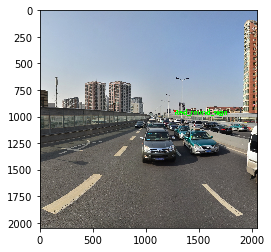

In [0]:
import matplotlib.patches as patches
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
import numpy as np

#image_plot = np.array(Image.open(("./Data/train_00/train_00/"+ train_image_ids[0])), dtype=np.uint8)

image_plot = Image.open("/content/red/JPEGImages/"+ image + '.jpg')

# Create figure and axes
fig, ax = plt.subplots(1)

for i in range(len (image_data_bbox)):
    
    xmin = image_data_bbox['XMin'].iloc[i]
    xmax = image_data_bbox['XMax'].iloc[i]
    ymin = image_data_bbox['YMin'].iloc[i]
    ymax = image_data_bbox['YMax'].iloc[i]

    width = xmax - xmin
    height = ymax - ymin
    
    # Scaling coordinates of bounding box to match the image size
    scaled_width = width*im.size[0]
    scaled_height = height*im.size[1]
    xmin_scaled = xmin*im.size[0]
    ymin_scaled = ymin*im.size[1]
    
    # Create a Rectangle patch
    rect = patches.Rectangle((xmin_scaled,ymin_scaled),scaled_width,scaled_height,linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    
    object_name = image_data_bbox['class_name'].iloc[i]
    
    draw = ImageDraw.Draw(image_plot)
    font = ImageFont.truetype("/content/futur.ttf", 60)
    draw.text((xmin_scaled, ymin_scaled),object_name,(0,255,0),font=font)
    
# Display the image
ax.imshow(image_plot)

   
plt.show()

**Helper functions**

In [0]:
import numpy as np
import os
import xml.etree.ElementTree as ET
import tensorflow as tf
import copy
import cv2

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, c = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.c     = c
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

class WeightReader:
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def reset(self):
        self.offset = 4

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

def draw_boxes(image, boxes, labels):
    image_h, image_w, _ = image.shape
    numb=len(boxes)
    print(numb)
    for box in boxes:
        xmin = int(box.xmin*image_w)
        ymin = int(box.ymin*image_h)
        xmax = int(box.xmax*image_w)
        ymax = int(box.ymax*image_h)

        cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,0,255), 3)
        cv2.putText(image, 
                    labels[box.get_label()] + ' ' + str(box.get_score()), 
                    (xmin, ymin + 20), 
                    cv2.FONT_HERSHEY_TRIPLEX, 
                    1e-3 * image_h, 
                    (255,0,0), 2)
        
    return image          
        
def decode_netout(netout, anchors, nb_class, obj_threshold=0.3, nms_threshold=0.3):
    grid_h, grid_w, nb_box = netout.shape[:3]

    boxes = []
    
    # decode the output by the network
    netout[..., 4]  = _sigmoid(netout[..., 4])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_threshold
    
    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(nb_box):
                # from 4th element onwards are confidence and class classes
                classes = netout[row,col,b,5:]
                
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout[row,col,b,:4]

                    x = (col + _sigmoid(x)) / grid_w # center position, unit: image width
                    y = (row + _sigmoid(y)) / grid_h # center position, unit: image height
                    w = anchors[2 * b + 0] * np.exp(w) / grid_w # unit: image width
                    h = anchors[2 * b + 1] * np.exp(h) / grid_h # unit: image height
                    confidence = netout[row,col,b,4]
                    
                    box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    
                    boxes.append(box)

    # suppress non-maximal boxes
    for c in range(nb_class):
        sorted_indices = list(reversed(np.argsort([box.classes[c] for box in boxes])))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            
            if boxes[index_i].classes[c] == 0: 
                continue
            else:
                for j in range(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]
                    
                    if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_threshold:
                        boxes[index_j].classes[c] = 0
                        
    # remove the boxes which are less likely than a obj_threshold
    boxes = [box for box in boxes if box.get_score() > obj_threshold]
    
    return boxes    

def compute_overlap(a, b):
    """
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    Parameters
    ----------
    a: (N, 4) ndarray of float
    b: (K, 4) ndarray of float
    Returns
    -------
    overlaps: (N, K) ndarray of overlap between boxes and query_boxes
    """
    area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])

    iw = np.minimum(np.expand_dims(a[:, 2], axis=1), b[:, 2]) - np.maximum(np.expand_dims(a[:, 0], 1), b[:, 0])
    ih = np.minimum(np.expand_dims(a[:, 3], axis=1), b[:, 3]) - np.maximum(np.expand_dims(a[:, 1], 1), b[:, 1])

    iw = np.maximum(iw, 0)
    ih = np.maximum(ih, 0)

    ua = np.expand_dims((a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1]), axis=1) + area - iw * ih

    ua = np.maximum(ua, np.finfo(float).eps)

    intersection = iw * ih

    return intersection / ua  
    
def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.

    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap      
        
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3          

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def _softmax(x, axis=-1, t=-100.):
    x = x - np.max(x)
    
    if np.min(x) < t:
        x = x/np.min(x)*t
        
    e_x = np.exp(x)
    
    return e_x / e_x.sum(axis, keepdims=True)

**Batch generator and augmentations**

In [0]:
import os
import cv2
import copy
import numpy as np
import imgaug as ia
from imgaug import augmenters as iaa
from keras.utils import Sequence
import xml.etree.ElementTree as ET
#from utils.utils import BoundBox, bbox_iou

class BatchGenerator(Sequence):
    def __init__(self, images, 
                       config, 
                       shuffle=True, 
                       jitter=True, 
                       norm=None):
        self.generator = None

        self.images = images
        self.config = config

        self.shuffle = shuffle
        self.jitter  = jitter
        self.norm    = norm

        self.anchors = [BoundBox(0, 0, config['ANCHORS'][2*i], config['ANCHORS'][2*i+1]) for i in range(int(len(config['ANCHORS'])//2))]

        ### augmentors by https://github.com/aleju/imgaug
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)

        # Define our sequence of augmentation steps that will be applied to every image
        # All augmenters with per_channel=0.5 will sample one value _per image_
        # in 50% of all cases. In all other cases they will sample new values
        # _per channel_.
        self.aug_pipe = iaa.Sequential(
            [
                sometimes(iaa.Affine(
                      )),
                # execute 0 to 5 of the following (less important) augmenters per image
                # don't execute all of them, as that would often be way too strong
                iaa.SomeOf((0, 5),
                    [
                        #sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                        iaa.OneOf([
                            iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                            iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                            iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                        ]),
                        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                        #iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                        # search either for all edges or for directed edges
                        #sometimes(iaa.OneOf([
                        #    iaa.EdgeDetect(alpha=(0, 0.7)),
                        #    iaa.DirectedEdgeDetect(alpha=(0, 0.7), direction=(0.0, 1.0)),
                        #])),
                        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                        iaa.OneOf([
                            iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                            #iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                        ]),
                        #iaa.Invert(0.05, per_channel=True), # invert color channels
                        iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                        iaa.Multiply((0.5, 1.5), per_channel=0.5), # change brightness of images (50-150% of original value)
                        iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                        #iaa.Grayscale(alpha=(0.0, 1.0)),
                        #sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                        #sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))) # sometimes move parts of the image around
                    ],
                    random_order=True
                )
            ],
            random_order=True
        )

        if shuffle: np.random.shuffle(self.images)

    def __len__(self):
        return int(np.ceil(float(len(self.images))/self.config['BATCH_SIZE']))   

    def num_classes(self):
        return len(self.config['LABELS'])

    def size(self):
        return len(self.images)    

    def load_annotation(self, i):
        annots = []

        for obj in self.images[i]['object']:
            annot = [obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax'], self.config['LABELS'].index(obj['name'])]
            annots += [annot]

        if len(annots) == 0: annots = [[]]

        return np.array(annots)

    def load_image(self, i):
        return cv2.imread(self.images[i]['filename'])

    def __getitem__(self, idx):
        l_bound = idx*self.config['BATCH_SIZE']
        r_bound = (idx+1)*self.config['BATCH_SIZE']

        if r_bound > len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - self.config['BATCH_SIZE']

        instance_count = 0

        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], self.config['IMAGE_W'], 3))                         # input images
        b_batch = np.zeros((r_bound - l_bound, 1     , 1     , 1    ,  self.config['TRUE_BOX_BUFFER'], 4))   # list of self.config['TRUE_self.config['BOX']_BUFFER'] GT boxes
        y_batch = np.zeros((r_bound - l_bound, self.config['GRID_H'],  self.config['GRID_W'], self.config['BOX'], 4+1+len(self.config['LABELS'])))                # desired network output

        for train_instance in self.images[l_bound:r_bound]:
            # augment input image and fix object's position and size
            img, all_objs = self.aug_image(train_instance, jitter=self.jitter)
            
            # construct output from object's x, y, w, h
            true_box_index = 0
            
            for obj in all_objs:
                if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in self.config['LABELS']:
                    center_x = .5*(obj['xmin'] + obj['xmax'])
                    center_x = center_x / (float(self.config['IMAGE_W']) / self.config['GRID_W'])
                    center_y = .5*(obj['ymin'] + obj['ymax'])
                    center_y = center_y / (float(self.config['IMAGE_H']) / self.config['GRID_H'])

                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))

                    if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                        obj_indx  = self.config['LABELS'].index(obj['name'])
                        
                        center_w = (obj['xmax'] - obj['xmin']) / (float(self.config['IMAGE_W']) / self.config['GRID_W']) # unit: grid cell
                        center_h = (obj['ymax'] - obj['ymin']) / (float(self.config['IMAGE_H']) / self.config['GRID_H']) # unit: grid cell
                        
                        box = [center_x, center_y, center_w, center_h]

                        # find the anchor that best predicts this box
                        best_anchor = -1
                        max_iou     = -1
                        
                        shifted_box = BoundBox(0, 
                                               0,
                                               center_w,                                                
                                               center_h)
                        
                        for i in range(len(self.anchors)):
                            anchor = self.anchors[i]
                            iou    = bbox_iou(shifted_box, anchor)
                            
                            if max_iou < iou:
                                best_anchor = i
                                max_iou     = iou
                                
                        # assign ground truth x, y, w, h, confidence and class probs to y_batch
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 4  ] = 1.
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 5+obj_indx] = 1
                        
                        # assign the true box to b_batch
                        b_batch[instance_count, 0, 0, 0, true_box_index] = box
                        
                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']
                            
            # assign input image to x_batch
            if self.norm != None: 
                x_batch[instance_count] = self.norm(img)
            else:
                # plot image and bounding boxes for sanity check
                for obj in all_objs:
                    if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin']:
                        cv2.rectangle(img[:,:,::-1], (obj['xmin'],obj['ymin']), (obj['xmax'],obj['ymax']), (255,0,0), 3)
                        cv2.putText(img[:,:,::-1], obj['name'], 
                                    (obj['xmin']+2, obj['ymin']+12), 
                                    0, 1.2e-3 * img.shape[0], 
                                    (0,255,0), 2)
                        
                x_batch[instance_count] = img

            # increase instance counter in current batch
            instance_count += 1  

        #print(' new batch created', idx)

        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle: np.random.shuffle(self.images)

    def aug_image(self, train_instance, jitter):
        image_name = train_instance['filename']
        image = cv2.imread(image_name)

        if image is None: print('Cannot find ', image_name)

        h, w, c = image.shape
        all_objs = copy.deepcopy(train_instance['object'])

        if jitter:
            ### scale the image
            scale = np.random.uniform() / 10. + 1.
            image = cv2.resize(image, (0,0), fx = scale, fy = scale)

            ### translate the image
            max_offx = (scale-1.) * w
            max_offy = (scale-1.) * h
            offx = int(np.random.uniform() * max_offx)
            offy = int(np.random.uniform() * max_offy)
            
            image = image[offy : (offy + h), offx : (offx + w)]

            ### flip the image
            flip = np.random.binomial(1, .5)
            if flip > 0.5: image = cv2.flip(image, 1)
                
            image = self.aug_pipe.augment_image(image)            
            
        # resize the image to standard size
        image = cv2.resize(image, (self.config['IMAGE_H'], self.config['IMAGE_W']))
        image = image[:,:,::-1]

        # fix object's position and size
        for obj in all_objs:
            for attr in ['xmin', 'xmax']:
                if jitter: obj[attr] = int(obj[attr] * scale - offx)
                    
                obj[attr] = int(obj[attr] * float(self.config['IMAGE_W']) / w)
                obj[attr] = max(min(obj[attr], self.config['IMAGE_W']), 0)
                
            for attr in ['ymin', 'ymax']:
                if jitter: obj[attr] = int(obj[attr] * scale - offy)
                    
                obj[attr] = int(obj[attr] * float(self.config['IMAGE_H']) / h)
                obj[attr] = max(min(obj[attr], self.config['IMAGE_H']), 0)

            if jitter and flip > 0.5:
                xmin = obj['xmin']
                obj['xmin'] = self.config['IMAGE_W'] - obj['xmax']
                obj['xmax'] = self.config['IMAGE_W'] - xmin
                
        return image, all_objs

**Configuations for the neural network**

In [0]:
LABELS = ['red_round_sign']

IMAGE_H, IMAGE_W = 2048, 2048
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
# Getting the total number of classes/labels we wil be predicting.
CLASS            = len(LABELS)
# Assigning 1's to all class labels
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')

# Pr (object in class) * Pr (class of the object) < Obj_threshold, then it disregards this anchor box
OBJ_THRESHOLD    = 0.3#0.5

# If there are many overlapping boxes and IOU is > NMS_thereshold, then we will drop the one with a lower probability. 
NMS_THRESHOLD    = 0.3#0.45

ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

In [0]:
wt_path = '/content/yolov3.weights'

In [0]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
#Here x is the input. This function basically converts height and widths to depths.
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

**GRAPH**

In [0]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
output = Lambda(lambda args: args[0])([output, true_boxes])

model = Model([input_image, true_boxes], output)

**Reading and converting the downloaded weights from a pretrained model**

In [0]:
#from utils.utils import WeightReader
weight_reader = WeightReader(wt_path)

In [0]:
weight_reader.reset()
nb_conv = 23

for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i))
    
    if i < nb_conv:
        norm_layer = model.get_layer('norm_' + str(i))
        
        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])       
        
    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

In [0]:
layer   = model.layers[-4] # the last convolutional layer
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias])

**Custom loss function taken from github**

In [0]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall) 

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss

In [0]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}

In [0]:
def normalize(image):
    return image / 255.

In [0]:
train_imgs = yolo_input_format_train

In [0]:
train_batch = BatchGenerator(train_imgs, generator_config, norm=normalize)

In [0]:
valid_imgs = yolo_input_format_val
valid_batch = BatchGenerator(valid_imgs, generator_config, norm=normalize, jitter=False)

**Callbacks**

In [0]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('weights_google_open_images.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

**Starting training**

In [0]:
tb_counter  = len([log for log in os.listdir(os.path.expanduser('/content/logs/')) if 'google_open_images_' in log]) + 1
tensorboard = TensorBoard(log_dir=os.path.expanduser('/content/logs/') + 'google_open_images_' + '_' + str(tb_counter), 
                           histogram_freq=0, 
                           write_graph=True, 
                           write_images=False)

optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=optimizer,metrics=['accuracy'])

model.fit_generator(generator        = train_batch, 
                    steps_per_epoch  = 10, 
                    epochs           = 100, 
                    verbose          = 1,
                    validation_data  = valid_batch,
                    validation_steps = 20,
                    callbacks        = [ checkpoint, tensorboard], 
                    max_queue_size   = 3)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
        with tf.control_dependencies([print_op]):
          out = tf.add(tensor, tensor)
        sess.run(out)
    ```
Additionally, to use tf.print in python 2.7, users must make sure to import
the following:

  `from __future__ import print_function`

Epoch 1/100
10/10 [==============================] - 99s 10s/step - loss: 0.1246 - acc: 0.2000 - val_loss: 0.1244 - val_acc: 0.2000

Epoch 00001: val_lo

**Loading new  weights for the trained model**

In [0]:
model.load_weights("weights_google_open_images.h5")

In [0]:
image = cv2.imread('/content/JPEGImages/0510b027c407c4a1.jpg')

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (416, 416))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])
#print(netout)
boxes = decode_netout(netout[0], 
                      obj_threshold=0.057,
                      nms_threshold=0.3,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
#print(boxes)           
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()